# Fixing some interesting plots

Thought :

do : create synthetic datasets where 50% of the data is synthetic, and show how long (duration), amplitude (how heigh), or frequency (power) needs to be added for the abnormality to be detectable for a simple CNN.


1st: set duration 100 ms, amplitude 1 --> Add frequency 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600 , 1700, 1800, 1900, 2000

2nd: Set frequency = 400 Hz, duration = 100, and do: amplitude 0.5 - 10 with 0.5 step

3rd: Set frequency = 400 Hz, amplitude = 1 --> add duration 50 ms to 1 s by 50 ms 

In [7]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(1, module_path + '/src')

import utility

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import skew 
import random

sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis
from sklearn.metrics import classification_report

from sklearn import preprocessing
from keras.utils import np_utils
import keras
from keras.models import Model
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

from sklearn.utils import shuffle
from hypopt import GridSearch

from time import time
import sys
import os

sys.path.insert(1, module_path + '/src/')

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 5000

import os
names = []
#files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
#files_path = '/home/andrine/Desktop/dataTromsoFiltered/allFilteres/'

import pickle

with open(module_path + '/data/tromsoSummary.pkl', 'rb') as f:
    data = pickle.load(f)
    

new_dataset = data[data['label'] == 'normal'].copy(deep = True).iloc[:4000]
del data

from sklearn.model_selection import train_test_split

new_dataset.sort_values(by=['nr'], inplace=True)

id_unique = new_dataset['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

new_dataset.reset_index(drop = False)


def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        indices = np.append([list(idx)] , [indices])
        
    return indices

indices_train = get_indices(id_train, new_dataset).astype(int)
indices_test = get_indices(id_test, new_dataset).astype(int)
indices_val = get_indices(id_val, new_dataset).astype(int)

In [8]:
def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new


lowcut = 150
highcut = 2000
FRAME_RATE = 5000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=12)

def get_sub_audios_no_overlap(audio, frac):
    base = len(audio)//frac
    sub_audio = []
    for n in range(frac):
        #print(n*base)
        if (n+1)*base < len(audio):
            sub = audio[n*base : (n+1)*base]
            sub_audio.append(sub)
            #print(len(sub))
        else:
            sub = audio[n*base :]
            #print(len(sub))
            diff = len(sub) - len(sub_audio[-1])
            if diff != 0:
                print(diff)
                sub = audio[n*base - diff :]
            sub_audio.append(sub)
            #print(len(sub))
            #print(diff)
    

    return sub_audio

def make_synthetic(audio, sr, dur , ampl,  freq ):
    random_offset = random.random()
    test = ampl*librosa.tone(freq, sr=sr, length=dur*sr, phi = random_offset)
    random_index = random.randint(0, len(audio) - len(test))
    new_audio = audio.copy()
    new_audio[random_index : random_index + len(test)] = new_audio[random_index : random_index + len(test)]  + test  
    return new_audio

def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))


def get_data_array(data, dur = 0.1, ampl = 1,  freq = 400 ):
    error_in_data = {}
    count = 0
    
    X = []
    y = []
    for row in data.iterrows():

        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000

            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            audio = znorm(audio)
            
            if (count%2 == 0):
                audio = make_synthetic(audio, sr, dur, ampl,  freq )
                label = 'synthetic'
            else:
                label = 'normal'
            
            audio = zero_pad(audio, 75000)
            #features = get_features(audio, sr)
            
            X.append(audio)
            y.append(label)
            
            
            count = count + 1
            
            '''
            sub_audio = get_sub_audios_no_overlap(audio, 3) # Set default 5 second window
            
            
            for sub in sub_audio:  
                
                if (count%2 == 0):
                    sub = make_synthetic(sub, sr, dur, ampl,  freq )
                    label = 'synthetic'
                else:
                    label = 'normal'
                   
                count = count + 1
                sub = zero_pad(sub, 25000)
                #sub = get_features(sub, sr)
                
                X.append(sub)
                y.append(label)
            '''

        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
    return (np.array(X), pd.Series(y))


def get_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=50))
    model.add(Conv1D(filters=50, kernel_size=6, activation='relu' ,  padding="same"))
    #model.add(MaxPooling1D(pool_size=100))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1500, activation='relu'))
    model.add(Dropout(0.25))

    #model.add(Dense(500, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    return model

def get_CNN_ready_dataset(y, le):
    num_classes = len(le.classes_)
    y =  le.transform(y)
    y = np_utils.to_categorical(y, num_classes = num_classes)
    return y

def get_random_forest_grid():
    parameters = {
    'n_estimators'      : [300,400,500],
    'max_depth'         : [8, 10, 12]}
    return GridSearch(model = RandomForestClassifier(criterion='entropy', random_state=42),
                      param_grid = parameters)


def get_preproject_acc_f1(X_train, y_train, X_val, y_val, X_test, y_test):
    #opt = get_random_forest_grid()
    #%time opt.fit(X_train, y_train, X_val, y_val,scoring = 'f1')
    clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)
    #X, y = np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val])
    clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_test)
    acc = classification_report(y_test, y_pred, output_dict = True)['accuracy']
    f1 = classification_report(y_test, y_pred, output_dict = True)['macro avg']['f1-score']
    return acc, f1, y_pred, y_test.to_numpy()

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)


# Frequency increase plot

Epoch 1/20
31/31 [==============================] - 153s 5s/step - loss: 5.3841 - accuracy: 0.4743 - val_loss: 0.7256 - val_accuracy: 0.4845
Epoch 2/20
31/31 [==============================] - 183s 6s/step - loss: 0.6586 - accuracy: 0.6344 - val_loss: 0.7972 - val_accuracy: 0.5005
Epoch 3/20
31/31 [==============================] - 149s 5s/step - loss: 0.4872 - accuracy: 0.7794 - val_loss: 0.9353 - val_accuracy: 0.4734
Epoch 4/20
31/31 [==============================] - 150s 5s/step - loss: 0.3300 - accuracy: 0.8710 - val_loss: 1.1791 - val_accuracy: 0.4654
Epoch 5/20
31/31 [==============================] - 145s 5s/step - loss: 0.3359 - accuracy: 0.8841 - val_loss: 1.5150 - val_accuracy: 0.4824
Epoch 6/20
31/31 [==============================] - 144s 5s/step - loss: 0.1160 - accuracy: 0.9720 - val_loss: 2.6552 - val_accuracy: 0.4774
Epoch 7/20
31/31 [==============================] - 157s 5s/step - loss: 0.1822 - accuracy: 0.9219 - val_loss: 2.3447 - val_accuracy: 0.4845
Epoch 8/20
31

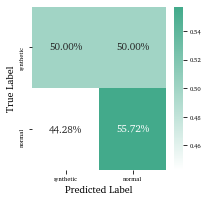

Epoch 1/20
31/31 [==============================] - 82s 3s/step - loss: 6.1227 - accuracy: 0.4930 - val_loss: 0.8394 - val_accuracy: 0.5005
Epoch 2/20
31/31 [==============================] - 80s 3s/step - loss: 0.6185 - accuracy: 0.6445 - val_loss: 0.7989 - val_accuracy: 0.4764
Epoch 3/20
31/31 [==============================] - 80s 3s/step - loss: 0.6425 - accuracy: 0.7190 - val_loss: 0.9149 - val_accuracy: 0.4855
Epoch 4/20
31/31 [==============================] - 81s 3s/step - loss: 0.3652 - accuracy: 0.8435 - val_loss: 1.1095 - val_accuracy: 0.4835
Epoch 5/20
31/31 [==============================] - 80s 3s/step - loss: 0.2919 - accuracy: 0.8805 - val_loss: 1.4596 - val_accuracy: 0.4774
Epoch 6/20
31/31 [==============================] - 78s 3s/step - loss: 0.1315 - accuracy: 0.9638 - val_loss: 1.8582 - val_accuracy: 0.4855
Epoch 7/20
31/31 [==============================] - 77s 2s/step - loss: 0.0664 - accuracy: 0.9893 - val_loss: 3.0626 - val_accuracy: 0.4674
Epoch 8/20
31/31 [==

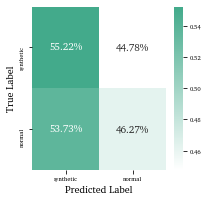

Epoch 1/20
31/31 [==============================] - 77s 2s/step - loss: 8.4296 - accuracy: 0.5096 - val_loss: 0.7171 - val_accuracy: 0.5025
Epoch 2/20
31/31 [==============================] - 76s 2s/step - loss: 0.6462 - accuracy: 0.6143 - val_loss: 0.8158 - val_accuracy: 0.5055
Epoch 3/20
31/31 [==============================] - 76s 2s/step - loss: 0.5497 - accuracy: 0.7245 - val_loss: 0.9241 - val_accuracy: 0.4875
Epoch 4/20
31/31 [==============================] - 77s 2s/step - loss: 0.4936 - accuracy: 0.7602 - val_loss: 1.0519 - val_accuracy: 0.4945
Epoch 5/20
31/31 [==============================] - 76s 2s/step - loss: 0.3323 - accuracy: 0.8625 - val_loss: 1.1968 - val_accuracy: 0.4965
Epoch 6/20
31/31 [==============================] - 76s 2s/step - loss: 0.1824 - accuracy: 0.9399 - val_loss: 1.5028 - val_accuracy: 0.4985
Epoch 7/20
31/31 [==============================] - 76s 2s/step - loss: 0.0770 - accuracy: 0.9858 - val_loss: 1.7849 - val_accuracy: 0.4995
Epoch 8/20
31/31 [==

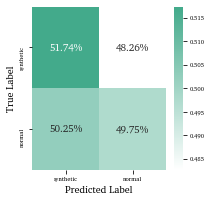

Epoch 1/20
31/31 [==============================] - 82s 3s/step - loss: 5.6604 - accuracy: 0.5005 - val_loss: 0.7061 - val_accuracy: 0.4965
Epoch 2/20
31/31 [==============================] - 78s 3s/step - loss: 0.6195 - accuracy: 0.6514 - val_loss: 0.7462 - val_accuracy: 0.5015
Epoch 3/20
31/31 [==============================] - 82s 3s/step - loss: 0.4915 - accuracy: 0.7649 - val_loss: 0.8986 - val_accuracy: 0.4895
Epoch 4/20
31/31 [==============================] - 80s 3s/step - loss: 0.3927 - accuracy: 0.8218 - val_loss: 1.1111 - val_accuracy: 0.4935
Epoch 5/20
31/31 [==============================] - 76s 2s/step - loss: 0.2505 - accuracy: 0.8959 - val_loss: 1.7348 - val_accuracy: 0.4885
Epoch 6/20
31/31 [==============================] - 76s 2s/step - loss: 0.1258 - accuracy: 0.9622 - val_loss: 1.8008 - val_accuracy: 0.4865
Epoch 7/20
31/31 [==============================] - 78s 3s/step - loss: 0.0480 - accuracy: 0.9940 - val_loss: 3.0135 - val_accuracy: 0.4995
Epoch 8/20
31/31 [==

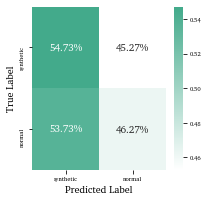

Epoch 1/20
31/31 [==============================] - 91s 3s/step - loss: 6.0814 - accuracy: 0.4947 - val_loss: 0.7220 - val_accuracy: 0.5035
Epoch 2/20
31/31 [==============================] - 79s 3s/step - loss: 0.5835 - accuracy: 0.6979 - val_loss: 0.7779 - val_accuracy: 0.5035
Epoch 3/20
31/31 [==============================] - 77s 2s/step - loss: 0.5373 - accuracy: 0.7699 - val_loss: 0.9384 - val_accuracy: 0.5115
Epoch 4/20
31/31 [==============================] - 77s 2s/step - loss: 0.3452 - accuracy: 0.8500 - val_loss: 1.2828 - val_accuracy: 0.5045
Epoch 5/20
31/31 [==============================] - 78s 3s/step - loss: 0.2549 - accuracy: 0.9059 - val_loss: 1.3675 - val_accuracy: 0.5005
Epoch 6/20
31/31 [==============================] - 76s 2s/step - loss: 0.1034 - accuracy: 0.9757 - val_loss: 1.8064 - val_accuracy: 0.4925
Epoch 7/20
31/31 [==============================] - 76s 2s/step - loss: 0.0402 - accuracy: 0.9961 - val_loss: 2.0997 - val_accuracy: 0.4955
Epoch 8/20
31/31 [==

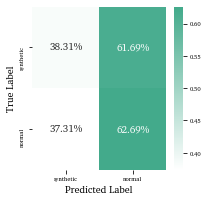

Epoch 1/20
31/31 [==============================] - 79s 3s/step - loss: 6.0116 - accuracy: 0.5245 - val_loss: 0.7071 - val_accuracy: 0.5075
Epoch 2/20
31/31 [==============================] - 79s 3s/step - loss: 0.6274 - accuracy: 0.6445 - val_loss: 0.8363 - val_accuracy: 0.5005
Epoch 3/20
31/31 [==============================] - 79s 3s/step - loss: 0.5111 - accuracy: 0.7388 - val_loss: 1.0129 - val_accuracy: 0.5025
Epoch 4/20
31/31 [==============================] - 83s 3s/step - loss: 0.3645 - accuracy: 0.8349 - val_loss: 1.1727 - val_accuracy: 0.5015
Epoch 5/20
31/31 [==============================] - 77s 2s/step - loss: 0.1958 - accuracy: 0.9307 - val_loss: 1.5707 - val_accuracy: 0.4895
Epoch 6/20
31/31 [==============================] - 77s 2s/step - loss: 0.0779 - accuracy: 0.9875 - val_loss: 3.2590 - val_accuracy: 0.5005
Epoch 7/20
31/31 [==============================] - 77s 2s/step - loss: 0.4323 - accuracy: 0.8767 - val_loss: 1.9433 - val_accuracy: 0.4915
Epoch 8/20
31/31 [==

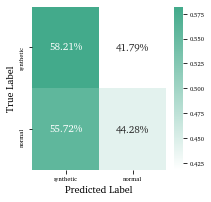

Epoch 1/20
31/31 [==============================] - 75s 2s/step - loss: 8.7533 - accuracy: 0.5040 - val_loss: 0.7883 - val_accuracy: 0.4995
Epoch 2/20
31/31 [==============================] - 75s 2s/step - loss: 0.6715 - accuracy: 0.5885 - val_loss: 2.0627 - val_accuracy: 0.5005
Epoch 3/20
31/31 [==============================] - 75s 2s/step - loss: 0.7764 - accuracy: 0.6873 - val_loss: 0.8816 - val_accuracy: 0.4925
Epoch 4/20
31/31 [==============================] - 75s 2s/step - loss: 0.4363 - accuracy: 0.7953 - val_loss: 0.9396 - val_accuracy: 0.4935
Epoch 5/20
31/31 [==============================] - 75s 2s/step - loss: 0.3048 - accuracy: 0.8880 - val_loss: 2.0040 - val_accuracy: 0.5085
Epoch 6/20
31/31 [==============================] - 75s 2s/step - loss: 0.3146 - accuracy: 0.8732 - val_loss: 1.7252 - val_accuracy: 0.4684
Epoch 7/20
31/31 [==============================] - 76s 2s/step - loss: 0.1326 - accuracy: 0.9647 - val_loss: 1.7066 - val_accuracy: 0.4824
Epoch 8/20
31/31 [==

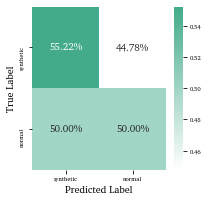

Epoch 1/20
31/31 [==============================] - 75s 2s/step - loss: 9.0597 - accuracy: 0.5087 - val_loss: 0.9706 - val_accuracy: 0.5005
Epoch 2/20
31/31 [==============================] - 75s 2s/step - loss: 0.7579 - accuracy: 0.5707 - val_loss: 0.7234 - val_accuracy: 0.4915
Epoch 3/20
31/31 [==============================] - 76s 2s/step - loss: 0.6291 - accuracy: 0.6367 - val_loss: 1.5983 - val_accuracy: 0.4975
Epoch 4/20
31/31 [==============================] - 75s 2s/step - loss: 0.6445 - accuracy: 0.6936 - val_loss: 0.8661 - val_accuracy: 0.4995
Epoch 5/20
31/31 [==============================] - 75s 2s/step - loss: 0.4261 - accuracy: 0.8051 - val_loss: 1.3005 - val_accuracy: 0.4985
Epoch 6/20
31/31 [==============================] - 75s 2s/step - loss: 0.3385 - accuracy: 0.8570 - val_loss: 2.4686 - val_accuracy: 0.5045
Epoch 7/20
31/31 [==============================] - 75s 2s/step - loss: 0.4180 - accuracy: 0.8563 - val_loss: 2.1393 - val_accuracy: 0.4955
Epoch 8/20
31/31 [==

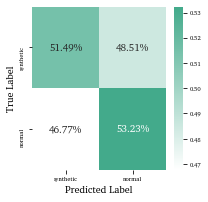

Epoch 1/20
31/31 [==============================] - 75s 2s/step - loss: 11.0871 - accuracy: 0.5027 - val_loss: 0.8246 - val_accuracy: 0.5035
Epoch 2/20
31/31 [==============================] - 75s 2s/step - loss: 0.6689 - accuracy: 0.5962 - val_loss: 0.8630 - val_accuracy: 0.5015
Epoch 3/20
31/31 [==============================] - 75s 2s/step - loss: 0.5710 - accuracy: 0.6877 - val_loss: 0.9647 - val_accuracy: 0.4794
Epoch 4/20
31/31 [==============================] - 75s 2s/step - loss: 0.4629 - accuracy: 0.7703 - val_loss: 1.1133 - val_accuracy: 0.4885
Epoch 5/20
31/31 [==============================] - 75s 2s/step - loss: 0.3787 - accuracy: 0.8312 - val_loss: 1.2177 - val_accuracy: 0.4774
Epoch 6/20
31/31 [==============================] - 76s 2s/step - loss: 0.2314 - accuracy: 0.9129 - val_loss: 1.6953 - val_accuracy: 0.4985
Epoch 7/20
31/31 [==============================] - 75s 2s/step - loss: 0.3112 - accuracy: 0.8846 - val_loss: 1.4100 - val_accuracy: 0.4804
Epoch 8/20
31/31 [=

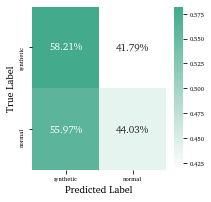

Epoch 1/20
31/31 [==============================] - 76s 2s/step - loss: 5.9802 - accuracy: 0.4790 - val_loss: 0.7171 - val_accuracy: 0.4855
Epoch 2/20
31/31 [==============================] - 75s 2s/step - loss: 0.8072 - accuracy: 0.6457 - val_loss: 0.7122 - val_accuracy: 0.4784
Epoch 3/20
31/31 [==============================] - 75s 2s/step - loss: 0.6542 - accuracy: 0.7444 - val_loss: 0.9394 - val_accuracy: 0.5045
Epoch 4/20
31/31 [==============================] - 75s 2s/step - loss: 0.4533 - accuracy: 0.7991 - val_loss: 0.9649 - val_accuracy: 0.5025
Epoch 5/20
31/31 [==============================] - 75s 2s/step - loss: 0.2857 - accuracy: 0.8992 - val_loss: 1.2721 - val_accuracy: 0.5095
Epoch 6/20
31/31 [==============================] - 75s 2s/step - loss: 0.1769 - accuracy: 0.9454 - val_loss: 1.8770 - val_accuracy: 0.4804
Epoch 7/20
31/31 [==============================] - 76s 2s/step - loss: 0.1044 - accuracy: 0.9664 - val_loss: 1.8851 - val_accuracy: 0.4985
Epoch 8/20
31/31 [==

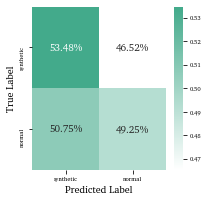

In [9]:
indices = {
    'train' : indices_train,
    'test' : indices_test,
    'val' : indices_val
    
}

result_datasets = {
    'train' : ([], []),
    'test' : ([], []),
    'val' : ([], [])
    
}

freqs = np.linspace(100, 2000, 10).astype(int)
ampls = np.linspace(0.5, 10, 10)
durs = np.linspace(0.01, 0.2, 10)

dur = 0.1
ampl = 1
freq = 400
acc_freqs = []
f1_freqs = []

for freq in freqs:
    #print(freq)
    # Get the datasets
    for name, i in indices.items():
        result_datasets[name] = get_data_array(new_dataset.iloc[i], dur, ampl, freq )
        
    X_train, y_train = result_datasets['train']
    X_test, y_test = result_datasets['test']
    X_val, y_val = result_datasets['val']
    
    classes = y_train.unique()
    
    # Preparing the data for the CNN
    le = preprocessing.LabelEncoder()

    le.fit(y_train)
    num_classes = len(le.classes_)
    X_train, y_train = shuffle(X_train, y_train, random_state = 42)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)


    y_train = get_CNN_ready_dataset(y_train, le)
    y_test = get_CNN_ready_dataset(y_test, le)
    y_val = get_CNN_ready_dataset(y_val, le)
    
    # Training a simple CNN
    
    batch_size = 100
    epochs = 20
    input_shape=(X_train.shape[1], 1)

    model = get_model(input_shape, num_classes)

    model.fit(X_train, y_train, epochs = epochs,
              batch_size = batch_size,
              verbose = 1,
             validation_data = (X_val, y_val))
    
    
    result = model.predict(X_test)
    y_pred = np.argmax(result, axis = 1)
    y_true = np.argmax(y_test, axis = 1)
    
    '''acc, f1, y_pred, y_true = get_preproject_acc_f1(X_train, y_train, X_val, y_val, X_test, y_test)
    f1_freqs.append(f1)
    acc_freqs.append(acc)'''
    
    f1_freqs.append(f1_score(y_true, y_pred))
    acc_freqs.append(accuracy_score(y_true, y_pred))
    
    f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = classes, color_index = 6)
    plt.show()
    
with open(module_path + '/src/visualization/synthetic_increase_acc_f1/acc_freqs_15_newCNN.pkl', 'wb') as f:
    pickle.dump(acc_freqs, f)
    
with open(module_path + '/src/visualization/synthetic_increase_acc_f1/f1_freqs_15_newCNN.pkl', 'wb') as f:
    pickle.dump(f1_freqs, f)

# Amplitude increase plot

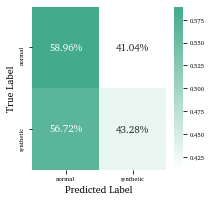

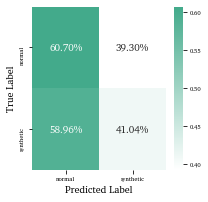

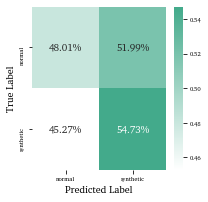

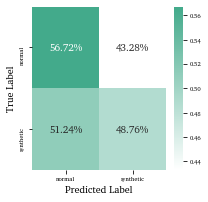

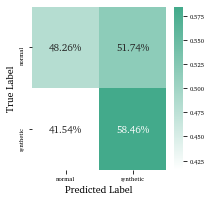

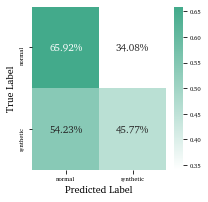

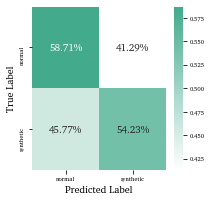

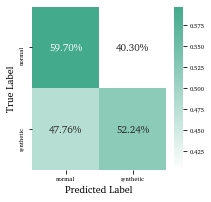

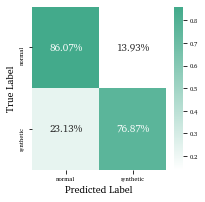

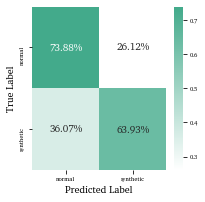

In [10]:
indices = {
    'train' : indices_train,
    'test' : indices_test,
    'val' : indices_val
    
}

result_datasets = {
    'train' : ([], []),
    'test' : ([], []),
    'val' : ([], [])
    
}

freqs = np.linspace(100, 2000, 10).astype(int)
ampls = np.linspace(0.5, 10, 10)
durs = np.linspace(0.01, 0.2, 10)

dur = 0.1
ampl = 1
freq = 400
acc_ampl = []
f1_ampl = []

for ampl in ampls:
    for name, i in indices.items():
        result_datasets[name] = get_data_array(new_dataset.iloc[i], dur, ampl, freq )
        
    X_train, y_train = result_datasets['train']
    X_test, y_test = result_datasets['test']
    X_val, y_val = result_datasets['val']
    
    classes = y_train.unique()
    
    # Preparing the data for the CNN
    le = preprocessing.LabelEncoder()

    le.fit(y_train)
    num_classes = len(le.classes_)
    X_train, y_train = shuffle(X_train, y_train, random_state = 42)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)


    y_train = get_CNN_ready_dataset(y_train, le)
    y_test = get_CNN_ready_dataset(y_test, le)
    y_val = get_CNN_ready_dataset(y_val, le)
    
    # Training a simple CNN
    
    batch_size = 100
    epochs = 20
    input_shape=(X_train.shape[1], 1)

    model = get_model(input_shape, num_classes)

    model.fit(X_train, y_train, epochs = epochs,
              batch_size = batch_size,
              verbose = 0,
             validation_data = (X_val, y_val))
    
    
    result = model.predict(X_test)
    y_pred = np.argmax(result, axis = 1)
    y_true = np.argmax(y_test, axis = 1)
    
    #acc, f1, y_pred, y_true = get_preproject_acc_f1(X_train, y_train, X_val, y_val, X_test, y_test)
    #f1_ampl.append(f1)
    #acc_ampl.append(acc)
    
    f1_ampl.append(f1_score(y_true, y_pred))
    acc_ampl.append(accuracy_score(y_true, y_pred))
    
    f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = le.classes_, color_index = 6)
    
with open(module_path + '/src/visualization/synthetic_increase_acc_f1/acc_ampls_15_newCNN.pkl', 'wb') as f:
    pickle.dump(acc_ampl, f)
    
with open(module_path + '/src/visualization/synthetic_increase_acc_f1/f1_ampls_15_newCNN.pkl', 'wb') as f:
    pickle.dump(f1_ampl, f)

# Duration increase plot

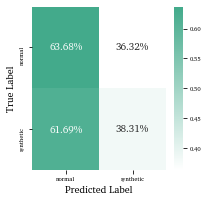

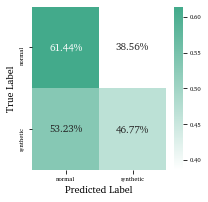

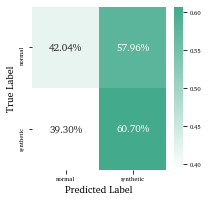

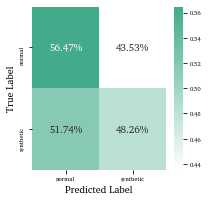

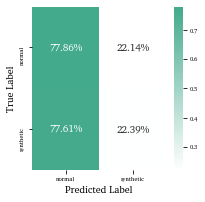

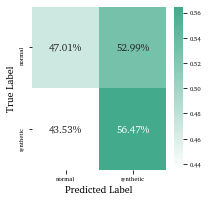

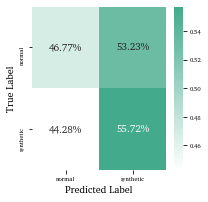

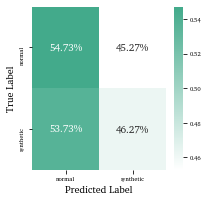

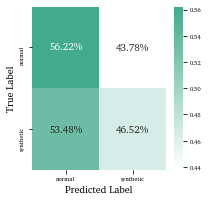

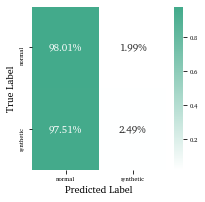

In [11]:
indices = {
    'train' : indices_train,
    'test' : indices_test,
    'val' : indices_val
    
}

result_datasets = {
    'train' : ([], []),
    'test' : ([], []),
    'val' : ([], [])
    
}

freqs = np.linspace(100, 2000, 10).astype(int)
ampls = np.linspace(0.5, 10, 10)
durs = np.linspace(0.01, 0.2, 10)

dur = 0.1
ampl = 1
freq = 400
acc_dur = []
f1_dur = []

for dur in durs:
    for name, i in indices.items():
        result_datasets[name] = get_data_array(new_dataset.iloc[i], dur, ampl, freq )
        
    X_train, y_train = result_datasets['train']
    X_test, y_test = result_datasets['test']
    X_val, y_val = result_datasets['val']
    
    classes = y_train.unique()
    
    # Preparing the data for the CNN
    le = preprocessing.LabelEncoder()

    le.fit(y_train)
    num_classes = len(le.classes_)
    X_train, y_train = shuffle(X_train, y_train, random_state = 42)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)


    y_train = get_CNN_ready_dataset(y_train, le)
    y_test = get_CNN_ready_dataset(y_test, le)
    y_val = get_CNN_ready_dataset(y_val, le)
    
    # Training a simple CNN
    
    batch_size = 100
    epochs = 20
    input_shape=(X_train.shape[1], 1)

    model = get_model(input_shape, num_classes)

    model.fit(X_train, y_train, epochs = epochs,
              batch_size = batch_size,
              verbose = 0,
             validation_data = (X_val, y_val))
    
    
    result = model.predict(X_test)
    y_pred = np.argmax(result, axis = 1)
    y_true = np.argmax(y_test, axis = 1)
    
    f1_dur.append(f1_score(y_true, y_pred))
    acc_dur.append(accuracy_score(y_true, y_pred))
    
    f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = le.classes_, color_index = 6)
    
with open(module_path + '/src/visualization/synthetic_increase_acc_f1/acc_durs_15_newCNN.pkl', 'wb') as f:
    pickle.dump(acc_dur, f)
    
with open(module_path + '/src/visualization/synthetic_increase_acc_f1/f1_durs_15_newCNN.pkl', 'wb') as f:
    pickle.dump(f1_dur, f)